# Reproducing experimental results

## 0. General settings

In [4]:
#----------------
# import modules
#----------------
import os
#用于操作文件和目录
# 创建目录、检查路径、获取文件名等
# 例如代码中用 os.makedirs() 创建数据集保存目
from utils.util import load_dataset
#用于加载数据集
#用于数据集的加载和预处理 从 pickle 文件中读取预处理好的数据

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
# plt: matplotlib 的主要绘图接口
# 用于绘制路线图、电量变化曲线等
# cm: colormap 颜色映射模块
# 提供不同的颜色方案，用于区分不同车辆和客户点
# animation: 动画模块
# 可能用于创建路径规划的动态可视化

import numpy as np



In [5]:
#---------------------
# user-defined params 
#---------------------
GPU              = 0
VEHICLE_SPEED    = 41.0 # km/h
WAIT_TIME        = 0.5  # h
TRAIN_BATCH_SIZE = 256
#内存管理

# 避免一次性加载所有训练数据
# 将数据分批处理，减少内存占用
# 训练效率

# 每批256个样本并行处理
# 加速训练过程
# GPU利用率更高
# 优化效果

# 每批样本更新一次模型参数
# 提供更稳定的梯度估计
# 有助于模型收敛
EVAL_BATCH_SIZE  = 256
MAX_BATCH_SIZE   = 12800
EVAL_SIZE        = 100
# 限制评估样本数：

# 从评估数据集中最多加载 100 个样本
# 用于控制评估时间和内存消耗
# 参数使用位置：
# eval(time_horizon=time_horizon,
#      ...
#      max_load_size=EVAL_SIZE,  # 这里限制评估样本数为100
#      ...)
TRAIN_EPOCH      = 0  # decrease training epoch to 0
TRAIN_SAMPLE     = 128 # decrese train sample
VALID_SAMPLE     = 1 # decrese train sample
EVAL_SAMPLE      = 1 # decrese train sample
RL_BASELINE      = "rollout"
RANDOM_SEED      = 1234
TRAIN_PATTERNS   = [ # train patterns就是不同的训练参数
    {
        "name": "ev12_n50_t12",
        "num_evs": 12,
        "num_locs": 50,
        "time_horizon": 12,
        "dropout": 0.2
    },
    {
        "name": "ev12_n25_t12", #locs当成客户
        "num_evs": 12, 
        "num_locs": 25, 
        "time_horizon": 12, 
        "dropout": 0.2
    },
    {
        "name": "ev6_n50_t12", 
        "num_evs": 6, 
        "num_locs": 50,
        "time_horizon": 12,
        "dropout": 0.2
    },
]
#-------------------------
# end user-defined params
#-------------------------


#---------------------------------------------
# the following params are automatically set,
# so DO NOT touch them
#---------------------------------------------

#-----------
# file name
#-----------
DATASET_DIR     = "data/syn_ev{num_evs}_n{num_locs}"  # 生成路径
CHECKPOINT_DIR  = "checkpoints/weight100_ev{num_evs}_n{num_locs}_t{time_horizon}_drop{dropout}" # 模型路径
#在训练复杂模型（如深度学习或强化学习模型）时，训练过程可能需要数小时、数天甚至更长时间。如果训练中断（例如由于电源故障或手动停止），没有检查点的话，之前的计算就会丢失。
#检查点允许你定期保存模型的参数（例如每完成一个 epoch 或达到某个性能指标时），这样可以在中断后从上一个检查点恢复训练，而不是从头开始。
OUTPUT_DIR      = "results/{dataset_name}_T{time_horizon}_evaluation/{model_name}" # 结果路径

#------------
# model list
#------------ 
model_list = [] # 之间不同模型参数下的模型列表
for train_params in TRAIN_PATTERNS: 
    num_evs  = train_params["num_evs"]
    num_locs = train_params["num_locs"]
    time_horizon = train_params["time_horizon"]
    dropout = train_params["dropout"]
    model = {
        "dataset_dir": DATASET_DIR.format(num_evs=num_evs, num_locs=num_locs),
        "checkpoint_dir": CHECKPOINT_DIR.format(num_evs=num_evs, num_locs=num_locs, time_horizon=time_horizon, dropout=dropout),
        "train_params": train_params
    }
    #键值对：每一行是一个键值对，例如：
#键 "dataset_dir" 对应值 DATASET_DIR.format(num_evs=num_evs, num_locs=num_locs)。
#键 "checkpoint_dir" 对应值 CHECKPOINT_DIR.format(num_evs=num_evs, num_locs=num_locs, time_horizon=time_horizon, dropout=dropout)。
#键 "train_params" 对应值 train_params
    model_list.append(model)

## 1. Generating synthetic datasets
It takes around 10 minutes to generate a dataset.

In [6]:
generated_dataset_list = []
for model in model_list:
    dataset_dir = model["dataset_dir"]
    if dataset_dir not in generated_dataset_list: # avoid duplicating the same dataset
        num_evs  = train_params["num_evs"]
        num_locs = train_params["num_locs"]
        !python generate_dataset.py --save_dir {dataset_dir} \
                                    --num_samples {TRAIN_SAMPLE} {VALID_SAMPLE} {EVAL_SAMPLE} \
                                    --num_vehicles {num_evs} \
                                    --num_locs {num_locs} \
                                    --random_seed {RANDOM_SEED}
    generated_dataset_list.append(dataset_dir)


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 6266.92it/s]
saving a dataset to data/syn_ev12_n50/train_dataset.pkl...done
saving a dataset to data/syn_ev12_n50/valid_dataset.pkl...done
saving a dataset to data/syn_ev12_n50/eval_dataset.pkl...done
100%|███████████████████████████████████████| 130/130 [00:00<00:00, 6166.63it/s]
saving a dataset to data/syn_ev12_n25/train_dataset.pkl...done
saving a dataset to data/syn_ev12_n25/valid_dataset.pkl...done
saving a dataset to data/syn_ev12_n25/eval_dataset.pkl...done
100%|███████████████████████████████████████| 130/130 [00:00<00:00, 6053.26it/s]
saving a dataset to data/syn_ev6_n50/train_dataset.pkl...done
saving a dataset to data/syn_ev6_n50/valid_dataset.pkl...done
saving a dataset to data/syn_ev6_n50/eval_dataset.pkl...done


## 2. Training models
A single RTX A6000 takes about 10 days to train a model for 100 epochs.  
Therefore, we recommend training models in parallel via the terminal, not this notebook.

In [7]:
def main(args):
# 在检查目录存在时自动处理
    if os.path.exists(args.checkpoint_dir):
        shutil.rmtree(args.checkpoint_dir)  # 直接删除旧目录
    os.makedirs(args.checkpoint_dir)

In [8]:
for model in model_list:
    dataset_path    = model["dataset_dir"] + "/train_dataset.pkl"
    checkpoint_dir  = model["checkpoint_dir"]
    num_evs         = model["train_params"]["num_evs"]
    num_locs      = model["train_params"]["num_locs"]
    time_horizon    = model["train_params"]["time_horizon"]
    dropout         = model["train_params"]["dropout"]
    # train
    !yes y |python train.py --dataset_path {dataset_path} \
                     --checkpoint_dir {checkpoint_dir} \
                     --time_horizon {time_horizon} \
                     --batch_size {TRAIN_BATCH_SIZE} \
                     --baseline {RL_BASELINE} \
                     --vehicle_speed {VEHICLE_SPEED} \
                     --wait_time {WAIT_TIME} \
                     --epoch {TRAIN_EPOCH} \
                     --dropout {dropout} \
                     --gpu -1\

The directory 'checkpoints/weight100_ev12_n50_t12_drop0.2' already exists. Do you want to overwrite it? [y/n]: selected device: CPU
100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]
Epoch 0: saving a model to checkpoints/weight100_ev12_n50_t12_drop0.2/model_epoch0.pth...done.
100%|██████████████████████████████████| 1/1 [00:16<00:00, 16.92s/it, cost=35.6]
evaluating current policy on evaluation dataset
100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]
Epoch 0 candidate mean 34.282371520996094, baseline epoch 0 mean 35.17182159423828, difference -0.8894500732421875
p-value: 8.535286873539083e-16
Update baseline
100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]
yes: stdout: Broken pipe
The directory 'checkpoints/weight100_ev12_n25_t12_drop0.2' already exists. Do you want to overwrite it? [y/n]: selected device: CPU
100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]
E

## 3. Hold-out Validation (Model selection)

In [9]:
for model in model_list:
    dataset_path = model["dataset_dir"] + "/valid_dataset.pkl"
    model_dir    = model["checkpoint_dir"]
    time_horizon = model["train_params"]["time_horizon"]
    # validate
    !yes y |python valid.py --model_dir {model_dir} \
                     --dataset_path {dataset_path} \
                     --eval_batch_size {EVAL_BATCH_SIZE} \
                     --vehicle_speed {VEHICLE_SPEED} \
                     --wait_time {WAIT_TIME} \
                     --time_horizon {time_horizon} \
                     --max_epoch {TRAIN_EPOCH} \
                     --gpu -1

Evaluating the model at epoch0 (currently best epoch is 0: cost=1000000000.0)
selected device: CPU
100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]
yes: stdout: Broken pipe
Evaluating the model at epoch0 (currently best epoch is 0: cost=1000000000.0)
selected device: CPU
100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]
yes: stdout: Broken pipe
Evaluating the model at epoch0 (currently best epoch is 0: cost=1000000000.0)
selected device: CPU
100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]
yes: stdout: Broken pipe


## 4. Quantitative evaluation

### 4.0. General Settings

In [10]:
competiter_list = [
    {
        "name": "wo_move",
        "model_type": "wo_move",
        "decode_type": None,
        "search_width": 1,
    },
    {
        "name": "greedy",
        "model_type": "naive_greedy",
        "decode_type": None,
        "search_width": 1,
    },
    {
        "name": "random",
        "model_type": "naive_random",
        "decode_type": None,
        "search_width": 10, # 深度降低一点 12800 改成10
    },
    {
        "name": "rlgreedy",
        "model_type": "rl",
        "decode_type": "greedy",
        "search_width": 1,
    },
    {
        "name": "rlsample1280",
        "model_type": "rl",
        "decode_type": "sampling",
        "search_width": 1, # 深度降低一点 12800 改成1
    },
    {
        "name": "rlsample12800",
        "model_type": "rl",
        "decode_type": "sampling",
        "search_width": 10, # 深度降低一点 12800 改成10
    },
]

In [11]:
import pandas as pd
import json
from typing import List, Dict, Any
from eval import eval

#---------------------
# evaluate all models
#---------------------
def eval_all(competiter_list: List[Dict[str, Any]],
             dataset_list: List[Dict[str, str]],
             timehorizon_list: List[int],
             visualize_routes: bool = False) -> None:
    for dataset_name, dataset_path, model_dir in dataset_list:
        for time_horizon in timehorizon_list:
            print(f"{dataset_name} T={time_horizon}")
            for competiter in competiter_list:
                print(competiter["model_type"], competiter["decode_type"], competiter["search_width"])
                output_dir = OUTPUT_DIR.format(dataset_name=dataset_name, time_horizon=time_horizon, model_name=competiter["name"])
                # evaluate
                eval(time_horizon=time_horizon,
                     model_type=competiter["model_type"],
                     decode_type=competiter["decode_type"],
                     search_width=competiter["search_width"],
                     dataset_path=dataset_path,
                     model_dir=model_dir,
                     output_dir=output_dir,
                     gpu=-1, # GPU改为-1
                     vehicle_speed=VEHICLE_SPEED,
                     wait_time=WAIT_TIME,
                     max_batch_size=MAX_BATCH_SIZE,
                     eval_batch_size=EVAL_BATCH_SIZE,
                     max_load_size=EVAL_SIZE,
                     visualize_routes=visualize_routes)

#----------------------------------
# summarize the evaluation results
#----------------------------------
def summarize_results(competiter_list: List[Dict[str, Any]],
                      dataset_list: List[Dict[str, str]],
                      timehorizon_list: List[int]) -> pd.DataFrame:
    idx = []; col1 = []; col2 = []; results = [[] for _ in range(len(competiter_list))]
    for i, competiter in enumerate(competiter_list):
        model_name = competiter["name"]
        idx.append(model_name)
        for dataset_name, dataset_path, model_dir in dataset_list:
            for time_horizon in timehorizon_list:
                if i == 0:
                    for eval_values in ["len.", "down", "obj", "time"]:
                        col1.append(f"{dataset_name}_T{time_horizon}")
                        col2.append(eval_values)
                # read a log file
                log_fname = OUTPUT_DIR.format(dataset_name=dataset_name, time_horizon=time_horizon, model_name=model_name) + "/summary.json"
                with open(log_fname, "r") as f:
                    res = json.load(f)
                    results[i].append(round(float(res["avg_actual_tour_length"]))) # (actual) route length
                    results[i].append(round(float(res["avg_num_down"]), 2))        # num down locs
                    results[i].append(round(float(res["avg_obj"]), 2))             # objevtive value
                    results[i].append(round(float(res["total_calc_time"]), 2))     # total calc time
    col = pd.MultiIndex.from_arrays([col1, col2])
    return pd.DataFrame(results, index=idx, columns=col)

### 4.1. Evaluation on synthetic datasets

In [12]:
syn_dataset_list = [
    ("SYN-EV6", "data/syn_ev6_n50/eval_dataset.pkl",   "checkpoints/weight100_ev6_n50_t12_drop0.2"),
    ("SYN-EV12", "data/syn_ev12_n50/eval_dataset.pkl", "checkpoints/weight100_ev12_n50_t12_drop0.2")
]
timehorizon_list = [12, 24] #把时间窗从12和24 之后改更小一点 但是单单做图 不能够继续调小

In [13]:
vis = True # 或者 False，根据需要选择是否启用可视化

In [14]:
eval_all(competiter_list, syn_dataset_list, timehorizon_list, vis)

SYN-EV6 T=12
wo_move None 1
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


naive_greedy None 1
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


naive_random None 10
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


rl greedy 1
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


rl sampling 1
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


rl sampling 10
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


SYN-EV6 T=24
wo_move None 1
selected device: CPU


100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


naive_greedy None 1
selected device: CPU


100%|██████████| 1/1 [00:04<00:00,  4.33s/it]


naive_random None 10
selected device: CPU


100%|██████████| 1/1 [00:04<00:00,  4.44s/it]


rl greedy 1
selected device: CPU


100%|██████████| 1/1 [00:04<00:00,  4.45s/it]


rl sampling 1
selected device: CPU


100%|██████████| 1/1 [00:04<00:00,  4.30s/it]


rl sampling 10
selected device: CPU


100%|██████████| 1/1 [00:04<00:00,  4.65s/it]


SYN-EV12 T=12
wo_move None 1
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


naive_greedy None 1
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


naive_random None 10
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


rl greedy 1
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


rl sampling 1
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


rl sampling 10
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


SYN-EV12 T=24
wo_move None 1
selected device: CPU


100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


naive_greedy None 1
selected device: CPU


100%|██████████| 1/1 [00:04<00:00,  4.52s/it]


naive_random None 10
selected device: CPU


100%|██████████| 1/1 [00:04<00:00,  4.53s/it]


rl greedy 1
selected device: CPU


100%|██████████| 1/1 [00:05<00:00,  5.14s/it]


rl sampling 1
selected device: CPU


100%|██████████| 1/1 [00:04<00:00,  4.34s/it]


rl sampling 10
selected device: CPU


100%|██████████| 1/1 [00:04<00:00,  4.54s/it]


In [15]:
summarize_results(competiter_list, syn_dataset_list, timehorizon_list)

SYN-EV6_T12                     SYN-EV6_T24                      \
                     len.   down    obj  time        len.   down    obj  time   
wo_move                 0  21.29  42.59  0.10           0  34.45  68.89  0.20   
greedy                213  19.14  40.41  0.03         370  30.59  64.87  0.06   
random                162  16.91  35.45  0.09         283  28.73  60.30  0.13   
rlgreedy              205  17.87  37.79  0.07         353  30.09  63.71  0.16   
rlsample1280          171  17.78  37.28  0.04         306  29.01  61.08  0.09   
rlsample12800         188  17.31  36.50  0.22         301  28.67  60.36  0.34   

              SYN-EV12_T12                     SYN-EV12_T24                \
                      len.   down    obj  time         len.   down    obj   
wo_move                  0  21.29  42.59  0.11            0  34.45  68.89   
greedy                 213  19.14  40.41  0.04          370  30.59  64.87   
random                 162  16.91  35.45  0.11          283  28.73  60.30   
rlgreedy               205  17.87  37.79  0.09          353  30.09  63.71   
rlsample1280           171  17.78  37.28  0.08          306  29.01  61.08   
rlsample12800          188  17.31  36.50  0.14          301  28.67  60.36   

                     
               time  
wo_move        0.24  
greedy         0.09  
random         0.16  
rlgreedy       0.17  
rlsample1280   0.15  
rlsample12800  0.30

### 4.2. Evaluation on real datasets (only private)
As we use our private dataset, you cannot conduct the experiments below.  
Please see the results just for reference purposes.

real_dataset_list = [
    ("REAL-EV6",  "data/real_datasets/real_ev6.pkl",   "checkpoints/weight100_ev6_n50_t12_drop0.2"),
    ("REAL-EV12",  "data/real_datasets/real_ev12.pkl",   "checkpoints/weight100_ev12_n50_t12_drop0.2"),
]
timehorizon_list = [12, 24]

eval_all(competiter_list, real_dataset_list, timehorizon_list, visualize_routes=True)

!pip install scikit-learn

#-----------------
# evaluate CP4TSN
#-----------------
dt_list = [
    ("tsn1",  1.0, None, None),
    ("tsn05", 0.5, None, None)
]
for dataset_name, dataset_path, _ in real_dataset_list:
    for time_horizon in timehorizon_list:
        print(f"{dataset_name} T={time_horizon}")
        for model_name, dt, _, __ in dt_list:
            print(model_name)
            output_dir = f"results/{dataset_name}_T{time_horizon}_evaluation/{model_name}"
            log_fname  = f"{output_dir}/summary.json"
            !python eval_cp4tsn.py --dataset_path {dataset_path} \
                                   --clustering \
                                   --cluster_type kmeans \
                                   --merge_duplicated_depots \
                                   --time_horizon {time_horizon} \
                                   --parallel \
                                   --num_cpus 12 \
                                   --limit_type time \
                                   --time_limit  1800 \
                                   --dt {dt} \
                                   --log_fname {log_fname}

tsn_list = [
    {
        "name": "tsn1",
        "model_type": 1.0,
        "decode_type": None,
        "search_width": None,
    },
    {
        "name": "tsn05",
        "model_type": 0.5,
        "decode_type": None,
        "search_width": None,
    },
]

all_competiter_list = competiter_list + tsn_list

summarize_results(all_competiter_list, real_dataset_list, timehorizon_list)

## 5. Visualization of routes

In [16]:
def get_color(id):
    cmap = plt.get_cmap("tab10")
    additional_colors = ["gold", "chartreuse"]
    if id <= 9:
        color = cmap(id)
    else:
        color = additional_colors[id - 10]
    return color

class BSColor():
    def __init__(self):
        self.idx_list = [0, 0, 0, 0]
    
    def get_color(self, init_batt):
        reds    = ["red", "salmon", "brown", "orangered"]
        greens  = ["gold", "orange", "goldenrod", "darkkhaki"]
        blues   = ["forestgreen", "limegreen", "darkgreen", "green", "lime", "seagreen", "mediumseagreen", "springgreen", 
                   "mediumspringgreen", "mediumaquamarine", "aquamarine", "turquoise", "lightseagreen", "mediumturquoise", "palegreen",
                   "lightgreen", "yellowgreen", "darkolivegreen", "greenyellow", "chartreuse", "lawngreen", "olive", "darkseagreen"]
        purples = ["purple", "midnightblue", "navy", "darkblue", "mediumblue", "blue", "slateblue", "darkslateblue", "mediumslateblue", "mediumpurple",
                   "steelblue", "cornflowerblue", "royalblue", "rebeccapurple", "blueviolet", "indigo", "darkorchid", "darkviolet", "mediumorchid", "plum", "violet", "darkmagenta"]
        
        if init_batt < 5.0:
            color = reds[self.idx_list[0]] if self.idx_list[0] < len(reds) else reds[0]
            self.idx_list[0] += 1
            return color, 3, 1
        elif init_batt >= 5.0 and init_batt <= 10:
            color = greens[self.idx_list[1]] if self.idx_list[1] < len(greens) else greens[0]
            self.idx_list[1] += 1
            return color, 2, 0.8
        elif init_batt >= 25 and init_batt <= 30: 
            color = blues[self.idx_list[2]] if self.idx_list[2] < len(blues) else blues[0]
            self.idx_list[2] += 1
            return color, 1, 0.6
        else:
            color = purples[self.idx_list[3]] if self.idx_list[3] < len(purples) else purples[0]
            self.idx_list[3] += 1
            return color, 0, 0.2


def visualize_route(ax, route_data):
    # add base stations & charge stations
    markersize = 8
    loc_coords = np.array(route_data["loc_coords"])
    dep_coords = np.array(route_data["depot_coords"])
    ignored_depots = np.array(route_data["ignored_depots"])
    x_loc = loc_coords[:, 0]; y_loc = loc_coords[:, 1]
    x_dep = dep_coords[:, 0]; y_dep = dep_coords[:, 1]
    ax.scatter(x_loc, y_loc, zorder=2, s=markersize, c="black", label="Base stations") # base stations
    ax.scatter(x_dep[~ignored_depots], y_dep[~ignored_depots], marker="s", zorder=2, s=markersize, c="none", ec="red", label="Charge stations") # charge stations
    
    # add routes
    routes = route_data["route"]
    coords = np.concatenate([loc_coords, dep_coords], axis=0)
    x_coo = coords[:, 0]; y_coo = coords[:, 1]
    num_vehicles = len(routes)
    for veh_id, route in enumerate(routes):
        color = get_color(veh_id)
        for i in range(len(route)-1):
            curr_id = route[i]
            next_id = route[i+1]
            st = coords[curr_id]
            end = coords[next_id]
            ax.annotate('', xy=end, xytext=st,
                        arrowprops=dict(shrink=0, width=0.5, headwidth=3, 
                        headlength=4, connectionstyle='arc3',
                        facecolor=color, edgecolor='none', alpha=0.5), zorder=1)
    ax.set_xticks([]); ax.set_yticks([])

Battery and route analysis figure saved to output_visuals/battery_route_analysis.png


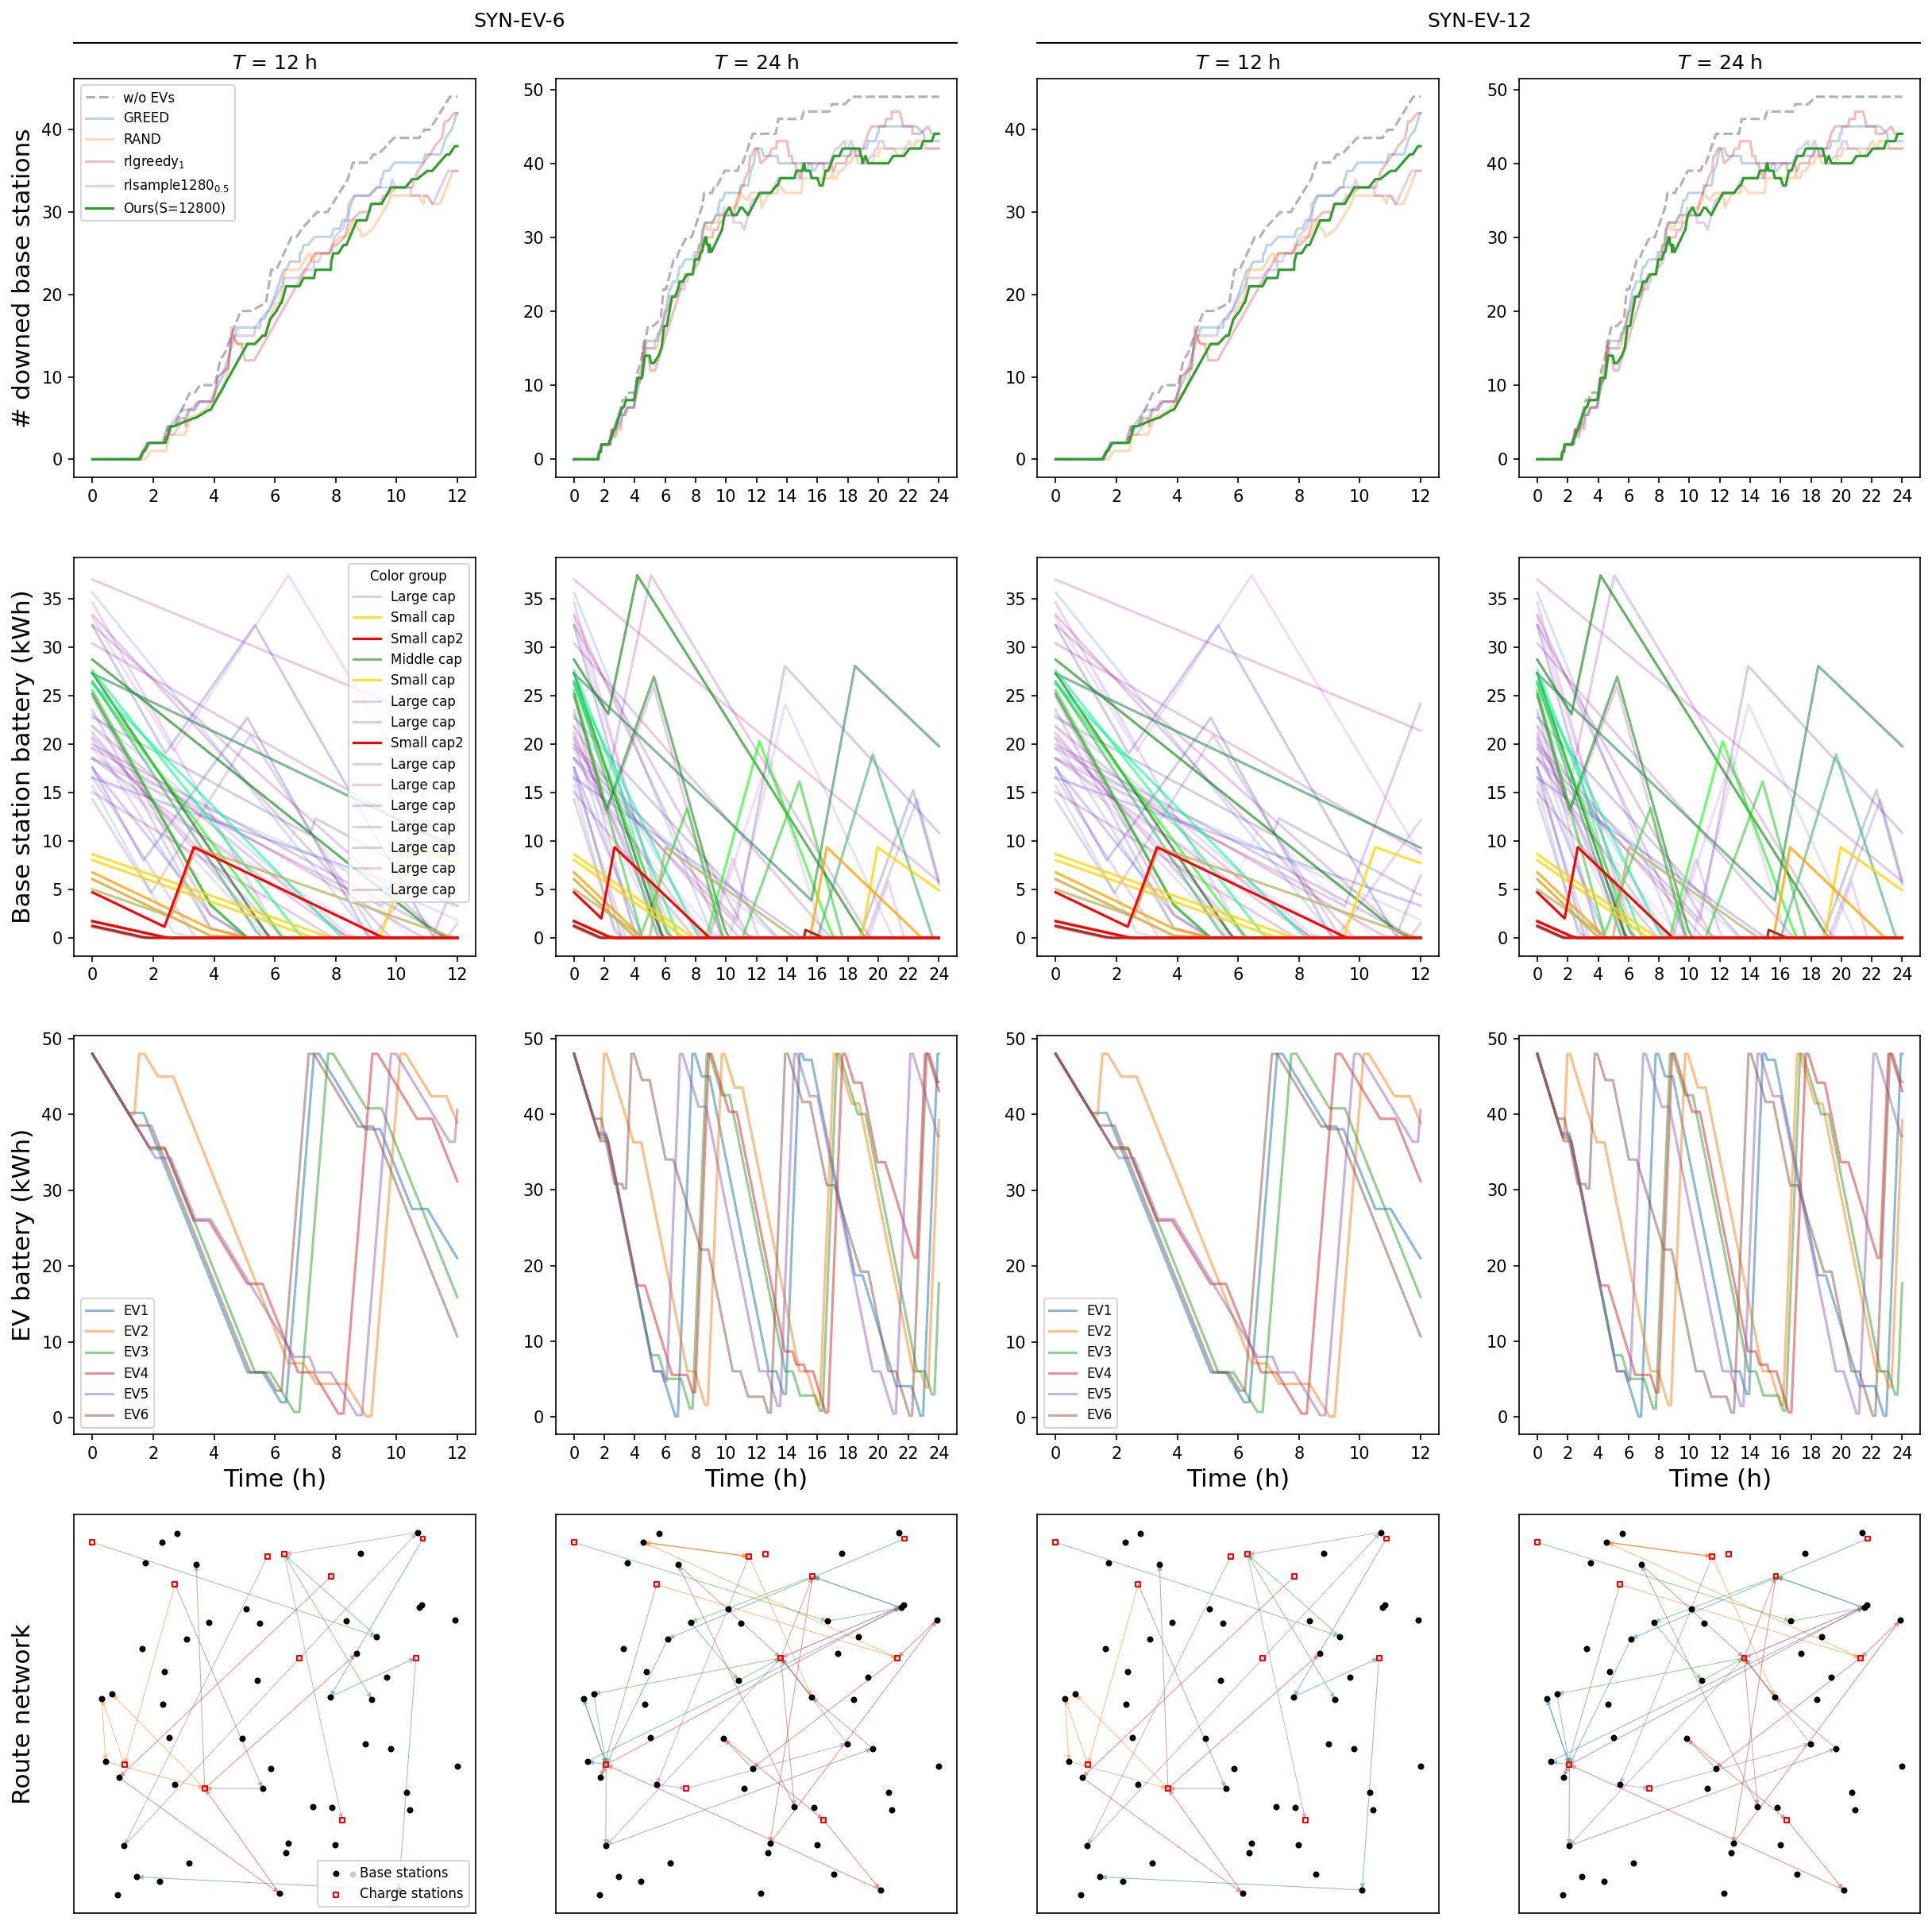

In [18]:
import pickle
from matplotlib.lines import Line2D
cmap = plt.get_cmap("tab10")

#------------------
# visual paramters
#------------------
DPI = 150
FONT_SIZE = 15
ALPHA = 0.3

# vis_dataset_list = [
#     ("REAL-EV6",  "data/real_datasets/real_ev6.pkl",   "checkpoints/weight100_ev6_n50_t12_drop0.2"),
#     ("REAL-EV12",  "data/real_datasets/real_ev12.pkl",   "checkpoints/weight100_ev12_n50_t12_drop0.2"),
# ]
# 做图看看 把real改为syn

vis_dataset_list = [
    ("SYN-EV6",  "data/SYN_datasets/SYN_ev6.pkl",   "checkpoints/weight100_ev6_n50_t12_drop0.2"),
    ("SYN-EV12",  "data/SYN_datasets/SYN_ev12.pkl",   "checkpoints/weight100_ev12_n50_t12_drop0.2"),
]
vis_timehorizon_list = [12, 24]
vis_model_list = [
    {
        "name": "wo_move",
        "label": "w/o EVs",
        "color": "black",
        "linestyle": "--"
    },
    {
        "name": "greedy",
        "label": "GREED",
        "color": cmap(0),
        "linestyle": "-"
    },
    {
        "name": "random",
        "label": "RAND",
        "color": cmap(1),
        "linestyle": "-"
    },
    {
        "name": "rlgreedy", # tsn1 -》rlgreedy
        "label": "rlgreedy$_1$", # CP-TSN-》rlgreedy
        "color": cmap(3),
        "linestyle": "-"
    },
    {
        "name": "rlsample1280",  # tsn05 -》rlsample1280
        "label": "rlsample1280$_{0.5}$",  # CP-TSN-》rlsample1280
        "color": cmap(4),
        "linestyle": "-"
    },
    {
        "name": "rlsample12800",
        "label": "Ours(S=12800)",
        "color": cmap(2),
        "linestyle": "-"
    },
]
output_route_model = "rlsample12800"
legend_color = {
    "red": "Small cap2", 
    "gold": "Small cap",
    "forestgreen": "Middle cap", 
    "purple": "Large cap"
}

#---------------
# visualization
#---------------
fig = plt.figure(figsize=(20, 20), dpi=DPI)
ax_dict = {}
for j, (dataset_name, dataset_path, _) in enumerate(vis_dataset_list):
    for i, time_horizon in enumerate(vis_timehorizon_list):
        prefix = f"{dataset_name}_T{time_horizon}"
        ev_batt_key    = f"{prefix}_ev_batt_hist"
        loc_batt_key   = f"{prefix}_loc_batt_hist"
        down_hist_key  = f"{prefix}_down_hist"
        route_key      = f"{prefix}_route"
        ax_dict[down_hist_key]  = fig.add_subplot(4, 4, 2*j + i + 1) # history of num. of downed base stations
        ax_dict[loc_batt_key]   = fig.add_subplot(4, 4, 2*j + i + 5) # history of Base station's battery
        ax_dict[ev_batt_key]    = fig.add_subplot(4, 4, 2*j + i + 9) # history of EV's battery
        ax_dict[route_key]      = fig.add_subplot(4, 4, 2*j + i + 13) # route

        for vis_model in vis_model_list:
            model_name = vis_model["name"]
            # load data
            res_dir = f"results/{dataset_name}_T{time_horizon}_evaluation/{model_name}/batch0-sample0"
            history_file = f"{res_dir}/history_data.pkl"

            # History of # of downed base stations
            with open(history_file, "rb") as f:
                history_data = pickle.load(f)
                alpha = 1 if model_name == output_route_model else ALPHA
                ax_dict[down_hist_key].plot(history_data["time"], history_data["down_loc"], c=vis_model["color"], label=vis_model["label"], linestyle=vis_model["linestyle"], alpha=alpha)
                ax_dict[down_hist_key].set_title(f"$T$ = {time_horizon} h")
                if i + j == 0: # The y-axis label and the legent are only present in the left-most figure.
                    ax_dict[down_hist_key].set_ylabel("# downed base stations", fontsize=FONT_SIZE)
                    ax_dict[down_hist_key].legend(fontsize=8)
                if time_horizon == 24:
                    ax_dict[down_hist_key].set_xticks(np.arange(0, 25, 2))

            if model_name == output_route_model:
                # Route visualization
                route_file = f"{res_dir}/route_info.pkl"
                with open(route_file, "rb") as f:
                    route_data = pickle.load(f)
                    visualize_route(ax_dict[route_key], route_data)
                    if i + j == 0: # The y-axis label is only present in the left-most figure.
                        ax_dict[route_key].set_ylabel("Route network", fontsize=FONT_SIZE)
                        ax_dict[route_key].legend(fontsize=8)
                        
                # Battery History
                with open(history_file, "rb") as f:
                    history_data = pickle.load(f)
                    # EV battery
                    cmap = plt.get_cmap("tab10")
                    for veh_id in range(len(history_data["veh_batt"])):
                        ax_dict[ev_batt_key].plot(history_data["time"], history_data["veh_batt"][veh_id], label=f"EV{veh_id+1}", color=get_color(veh_id), alpha=0.5)
                        ax_dict[ev_batt_key].set_xlabel("Time (h)", fontsize=FONT_SIZE)
                        if i + j == 0: # The y-axis label is only present in the left-most figure.
                            ax_dict[ev_batt_key].set_ylabel("EV battery (kWh)", fontsize=FONT_SIZE)
                            ax_dict[ev_batt_key].legend(fontsize=8)
                        if 2*j + i + 9 == 11:
                            ax_dict[ev_batt_key].legend(fontsize=8)
                        if time_horizon == 24:
                            ax_dict[ev_batt_key].set_xticks(np.arange(0, 25, 2))
                            
                    # Base station battery
                    bs_color = BSColor() 
                    for loc_id in range(len(history_data["loc_batt"])):
                        init_batt = history_data["loc_batt"][loc_id][0]
                        color, zorder, alpha = bs_color.get_color(init_batt)
                        label = None if color not in list(legend_color.keys()) else legend_color[color] 
                        ax_dict[loc_batt_key].plot(history_data["time"], history_data["loc_batt"][loc_id], alpha=alpha, color=color, zorder=zorder, label=label)
                        if i + j == 0: # The y-axis label is only present in the left-most figure.
                            ax_dict[loc_batt_key].set_ylabel("Base station battery (kWh)", fontsize=FONT_SIZE)
                            ax_dict[loc_batt_key].legend(title="Color group", title_fontsize=8, fontsize=8)
                        if time_horizon == 24:
                            ax_dict[loc_batt_key].set_xticks(np.arange(0, 25, 2))

# # title setting
# Y_OFFSET = 0.015
# fig.text(0.312, 0.9, 'REAL-EV-6', ha='center', va='bottom', fontsize=12)
# fig.text(0.715, 0.9, 'REAL-EV-12', ha='center', va='bottom', fontsize=12)
# left_ax  = ax_dict["REAL-EV6_T12_down_hist"].get_position()
# right_ax = ax_dict["REAL-EV6_T24_down_hist"].get_position()
# fig.add_artist(Line2D([left_ax.x0, right_ax.x1], [left_ax.y1 + Y_OFFSET, left_ax.y1 + Y_OFFSET], color="black", transform=fig.transFigure, linewidth=1))
# left_ax  = ax_dict["REAL-EV12_T12_down_hist"].get_position()
# right_ax = ax_dict["REAL-EV12_T24_down_hist"].get_position()
# fig.add_artist(Line2D([left_ax.x0, right_ax.x1], [left_ax.y1 + Y_OFFSET, left_ax.y1 + Y_OFFSET], color="black", transform=fig.transFigure, linewidth=1))
# fig.align_labels([ax for ax in ax_dict.values()])
#把原来论文的这部分进行该写

# title setting
Y_OFFSET = 0.015
fig.text(0.312, 0.9, 'SYN-EV-6', ha='center', va='bottom', fontsize=12)
fig.text(0.715, 0.9, 'SYN-EV-12', ha='center', va='bottom', fontsize=12)
left_ax  = ax_dict["SYN-EV6_T12_down_hist"].get_position()
right_ax = ax_dict["SYN-EV6_T24_down_hist"].get_position()
fig.add_artist(Line2D([left_ax.x0, right_ax.x1], [left_ax.y1 + Y_OFFSET, left_ax.y1 + Y_OFFSET], color="black", transform=fig.transFigure, linewidth=1))
left_ax  = ax_dict["SYN-EV12_T12_down_hist"].get_position()
right_ax = ax_dict["SYN-EV12_T24_down_hist"].get_position()
fig.add_artist(Line2D([left_ax.x0, right_ax.x1], [left_ax.y1 + Y_OFFSET, left_ax.y1 + Y_OFFSET], color="black", transform=fig.transFigure, linewidth=1))
fig.align_labels([ax for ax in ax_dict.values()])

# 保存可视化结果
# 确保输出目录存在
import os
os.makedirs('output_visuals', exist_ok=True)

# 生成图片文件名
base_name = 'output_visuals/battery_route_analysis.png'
counter = 0
output_file = base_name

# 如果文件存在，添加编号
while os.path.exists(output_file):
    counter += 1
    output_file = f'output_visuals/battery_route_analysis_{counter}.png'

# 保存图片，使用已设定的 DPI 值
plt.savefig(output_file, bbox_inches='tight', dpi=DPI)
print(f"Battery and route analysis figure saved to {output_file}")



## 6. Computational Scalability Test & Generalization Test

In [21]:
# RANDOM_SEED = 0
# NUM_SAMPLES = 100
# GPU = 0
# time_horizon_list = [12, 24, 36, 48]
# num_loc_list      = [25, 50, 75, 100]
# num_ev_list       = [6, 12, 18, 24]

# 改一下 规模小一点
RANDOM_SEED = 0
NUM_SAMPLES = 1 # 100->1
GPU = -1
time_horizon_list = [3, 6, 9, 12]  # 3 6 9 12
num_loc_list      = [5, 10, 15, 20] # 5 10 15 20
num_ev_list       = [3, 6, 9, 12] #2 4 6 8

# time_horizon_list = [12, 24, 36, 48]  # 3 6 9 12
# num_loc_list      = [25, 50, 75, 100] # 5 10 12 20
# num_ev_list       = [6, 12, 18, 24] #2 4 6 8


### 6.1. Generating new evaluation datasets for scalability & generalization tests 

In [22]:
# for time horizon
!python generate_dataset.py --num_locs 25 \
                            --num_vehicles 12 \
                            --save_dir data/gen_scale_test/test_time_horizon \
                            --type eval \
                            --num_samples {NUM_SAMPLES} \
                            --random_seed {RANDOM_SEED}

# for num_locs
for num_locs in num_loc_list:
    !python generate_dataset.py --num_locs {num_locs} \
                                --num_vehicles 12 \
                                --save_dir data/gen_scale_test/test_num_nodes{num_locs} \
                                --type eval \
                                --num_samples {NUM_SAMPLES} \
                                --random_seed {RANDOM_SEED}

# for num_evs
for num_evs in num_ev_list:
    !python generate_dataset.py --num_locs 50 \
                                --num_depots {num_evs} \
                                --num_vehicles {num_evs} \
                                --save_dir data/gen_scale_test/test_num_evs{num_evs} \
                                --type eval \
                                --num_samples {NUM_SAMPLES} \
                                --random_seed {RANDOM_SEED}

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 359.44it/s]
saving a dataset to data/gen_scale_test/test_time_horizon/eval_dataset.pkl...done
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 864.98it/s]
saving a dataset to data/gen_scale_test/test_num_nodes5/eval_dataset.pkl...done
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 777.01it/s]
saving a dataset to data/gen_scale_test/test_num_nodes10/eval_dataset.pkl...done
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 851.64it/s]
saving a dataset to data/gen_scale_test/test_num_nodes15/eval_dataset.pkl...done
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 907.47it/s]
saving a dataset to data/gen_scale_test/test_num_nodes20/eval_dataset.pkl...done
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 722.41it/s]
saving a dataset to data/gen_scale_test/test_num_evs3/eval_dataset.pkl...done
100%|██████████████████████████

### 6.2. Evaluation (objective value and calculation time)

In [23]:
from typing import Union
import subprocess

def call_eval(model_dir: str,
              model_type: str,
              dataset_path: str,
              time_horizon: float,
              decode_type: Union[str, float],
              search_width: int,
              output_dir: str) -> None:
    if model_type == "cp4tsn":
        # evaluate CP4TSN
        command = f"python eval_cp4tsn.py --dataset_path {dataset_path} " \
                  f"--time_horizon {time_horizon} --clustering " \
                  f"--cluster_type kmeans --parallel --num_cpus 24 " \
                  f"--limit_type time --time_limit {search_width} " \
                  f"--dt {decode_type} --log_fname {output_dir}/log.txt"
        subprocess.run(command, shell=True)
    else:    
        # evaluate naive & RL models
        eval(time_horizon=time_horizon,
             model_type=model_type,
             decode_type=decode_type,
             search_width=search_width,
             dataset_path=dataset_path,
             model_dir=model_dir,
             output_dir=output_dir,
             gpu=-1, # 改为-1
             vehicle_speed=VEHICLE_SPEED,
             wait_time=WAIT_TIME,
             max_batch_size=MAX_BATCH_SIZE,
             eval_batch_size=1)

In [24]:
# we use the weights trained on REAL-EV-6S (num_evs=6, num_locs=25, T=12)
cmap = plt.get_cmap("tab10")
eval_model_list = [
    # we do not evaluate tsn here because "IndexError: list index out of range" occurs, and that is impracticable
    # {
    #     "name": "tsn1",
    #     "label": "CP-TSN$_1$",
    #     "model_type": "cp4tsn",
    #     "decode_type": 1.0, # dt
    #     "color": cmap(3),
    #     "marker": "^",
    #     "search_width": 1800, # time limit (s)
    # },
    # {
    #     "name": "tsn05",
    #     "label": "CP-TSN$_{0.5}$",
    #     "model_type": "cp4tsn",
    #     "decode_type": 0.5, # dt
    #     "color": cmap(4),
    #     "marker": "x",
    #     "search_width": 1800, # time limit (s)
    # },
    {
        "name": "greedy",
        "label": "GREED",
        "model_type": "naive_greedy",
        "decode_type": None,
        "color": cmap(0),
        "marker": "d",
        "search_width": 1,
    },
    {
        "name": "random",
        "label": "RAND",
        "color": cmap(1),
        "marker": "p",
        "model_type": "naive_random",
        "decode_type": None,
        "search_width": 12800,
    },
    {
        "name": "rlgreedy",
        "label": "Ours (G)", 
        "model_type": "rl",
        "color": cmap(5),
        "marker": "o",
        "decode_type": "greedy",
        "search_width": 1,
    },
    {
        "name": "rlsample1280",
        "label": "Ours (S=1280)",
        "model_type": "rl",
        "color": cmap(6),
        "marker": "s",
        "decode_type": "sampling",
        "search_width": 1280,
    },
    {
        "name": "rlsample12800",
        "label": "Ours (S=12800)",
        "model_type": "rl",
        "color": cmap(2),
        "marker": "*",
        "decode_type": "sampling",
        "search_width": 12800,
    },
]

In [25]:
# for time horizon
MODEL_DIR = "checkpoints/weight100_ev12_n25_t12_drop0.2"
dataset_path = "data/gen_scale_test/test_time_horizon/eval_dataset.pkl"
for eval_model in eval_model_list:
    for time_horizon in time_horizon_list:
        print(f"T = {time_horizon}")
        output_dir = f"results/test_time_horizon/{eval_model['name']}_time_horizon{time_horizon}"
        call_eval(model_dir=MODEL_DIR,
                  dataset_path=dataset_path,
                  time_horizon=time_horizon,
                  model_type=eval_model["model_type"],
                  decode_type=eval_model["decode_type"],
                  search_width=eval_model["search_width"],
                  output_dir=output_dir)

# for num_locs
MODEL_DIR = "checkpoints/weight100_ev12_n25_t12_drop0.2"
for eval_model in eval_model_list:
    for num_locs in num_loc_list:
        print(f"num_locs = {num_locs}")
        dataset_path = f"data/gen_scale_test/test_num_nodes{num_locs}/eval_dataset.pkl"
        output_dir = f"results/test_num_locs/{eval_model['name']}_num_locs{num_locs}"
        call_eval(model_dir=MODEL_DIR,
                  dataset_path=dataset_path,
                  time_horizon=12,
                  model_type=eval_model["model_type"],
                  decode_type=eval_model["decode_type"],
                  search_width=eval_model["search_width"],
                  output_dir=output_dir)
        
# for num_evs
MODEL_DIR = "checkpoints/weight100_ev6_n50_t12_drop0.2"
for eval_model in eval_model_list:
    for num_evs in num_ev_list:
        print(f"num_evs = {num_evs}")
        dataset_path = f"data/gen_scale_test/test_num_evs{num_evs}/eval_dataset.pkl"
        output_dir = f"results/test_num_evs/{eval_model['name']}_num_evs{num_evs}"
        call_eval(model_dir=MODEL_DIR,
                  dataset_path=dataset_path,
                  time_horizon=12,
                  model_type=eval_model["model_type"],
                  decode_type=eval_model["decode_type"],
                  search_width=eval_model["search_width"],
                  output_dir=output_dir)

T = 3
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


T = 6
selected device: CPU


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


T = 9
selected device: CPU


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


T = 12
selected device: CPU


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


T = 3
selected device: CPU


100%|██████████| 1/1 [00:03<00:00,  3.76s/it]


T = 6
selected device: CPU


100%|██████████| 1/1 [00:05<00:00,  5.00s/it]


T = 9
selected device: CPU


100%|██████████| 1/1 [00:07<00:00,  7.24s/it]


T = 12
selected device: CPU


100%|██████████| 1/1 [00:09<00:00,  9.10s/it]


T = 3
selected device: CPU


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


T = 6
selected device: CPU


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


T = 9
selected device: CPU


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


T = 12
selected device: CPU


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


T = 3
selected device: CPU


100%|██████████| 1/1 [00:08<00:00,  8.60s/it]


T = 6
selected device: CPU


100%|██████████| 1/1 [00:11<00:00, 11.97s/it]


T = 9
selected device: CPU


100%|██████████| 1/1 [00:15<00:00, 15.88s/it]


T = 12
selected device: CPU


100%|██████████| 1/1 [00:20<00:00, 20.47s/it]


T = 3
selected device: CPU


100%|██████████| 1/1 [01:29<00:00, 89.33s/it]


T = 6
selected device: CPU


100%|██████████| 1/1 [02:26<00:00, 146.28s/it]


T = 9
selected device: CPU


100%|██████████| 1/1 [03:26<00:00, 206.58s/it]


T = 12
selected device: CPU


100%|██████████| 1/1 [04:11<00:00, 251.31s/it]


num_locs = 5
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


num_locs = 10
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


num_locs = 15
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


num_locs = 20
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


num_locs = 5
selected device: CPU


100%|██████████| 1/1 [00:14<00:00, 14.05s/it]


num_locs = 10
selected device: CPU


100%|██████████| 1/1 [00:13<00:00, 13.33s/it]


num_locs = 15
selected device: CPU


100%|██████████| 1/1 [00:13<00:00, 13.52s/it]


num_locs = 20
selected device: CPU


100%|██████████| 1/1 [00:15<00:00, 15.17s/it]


num_locs = 5
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


num_locs = 10
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


num_locs = 15
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


num_locs = 20
selected device: CPU


100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


num_locs = 5
selected device: CPU


100%|██████████| 1/1 [00:23<00:00, 23.58s/it]


num_locs = 10
selected device: CPU


100%|██████████| 1/1 [00:21<00:00, 21.33s/it]


num_locs = 15
selected device: CPU


100%|██████████| 1/1 [00:22<00:00, 22.67s/it]


num_locs = 20
selected device: CPU


100%|██████████| 1/1 [00:24<00:00, 24.17s/it]


num_locs = 5
selected device: CPU


100%|██████████| 1/1 [03:56<00:00, 236.92s/it]


num_locs = 10
selected device: CPU


100%|██████████| 1/1 [03:56<00:00, 236.10s/it]


num_locs = 15
selected device: CPU


100%|██████████| 1/1 [03:40<00:00, 220.60s/it]


num_locs = 20
selected device: CPU


100%|██████████| 1/1 [03:44<00:00, 224.08s/it]


num_evs = 3
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


num_evs = 6
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


num_evs = 9
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


num_evs = 12
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


num_evs = 3
selected device: CPU


100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


num_evs = 6
selected device: CPU


100%|██████████| 1/1 [00:05<00:00,  6.00s/it]


num_evs = 9
selected device: CPU


100%|██████████| 1/1 [00:09<00:00,  9.88s/it]


num_evs = 12
selected device: CPU


100%|██████████| 1/1 [00:16<00:00, 16.07s/it]


num_evs = 3
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


num_evs = 6
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


num_evs = 9
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


num_evs = 12
selected device: CPU


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


num_evs = 3
selected device: CPU


100%|██████████| 1/1 [00:08<00:00,  8.86s/it]


num_evs = 6
selected device: CPU


100%|██████████| 1/1 [00:16<00:00, 16.02s/it]


num_evs = 9
selected device: CPU


100%|██████████| 1/1 [00:25<00:00, 25.25s/it]


num_evs = 12
selected device: CPU


100%|██████████| 1/1 [00:36<00:00, 36.61s/it]


num_evs = 3
selected device: CPU


100%|██████████| 1/1 [01:27<00:00, 87.46s/it]


num_evs = 6
selected device: CPU


100%|██████████| 1/1 [03:04<00:00, 184.53s/it]


num_evs = 9
selected device: CPU


100%|██████████| 1/1 [04:18<00:00, 258.34s/it]


num_evs = 12
selected device: CPU


100%|██████████| 1/1 [06:43<00:00, 403.66s/it]


### 6.3. Plotting thr results of scalability & generalization tests

In [26]:
import matplotlib
import matplotlib.pyplot as plt
markersize = 8
capsize = 5

def plot_scale_gen_res(model_list,
                       ax_dict: Dict[str, matplotlib.axes.Axes],
                       lst: List[int],
                       get_log_fname,
                       xlabel: str = None,
                       ylabel_scale: str = None,
                       ylabel_gen: str = None) -> dict:
    res = {"obj": {}, "time": {}, "obj_std": {}, "time_std": {}}
    for id, model in enumerate(model_list):
        model_name = model["name"]
        res["obj"][model_name] = []
        res["time"][model_name] = []
        res["obj_std"][model_name] = []
        res["time_std"][model_name] = []
        for elem in lst:
            log_fname = get_log_fname(model_name, elem)
            with open(log_fname, "r") as f:
                res_ = json.load(f)
            res["obj"][model_name].append(float(res_["avg_obj"]))        # objevtive value
            res["time"][model_name].append(float(res_["avg_calc_time"])) # averaged calc time per one sample
            res["obj_std"][model_name].append(float(res_["std_obj"]))        # std of objevtive values
            res["time_std"][model_name].append(float(res_["std_calc_time"])) # std of averaged calc time per one sample
    
        def vis_graph(ax_dict_: Dict[str, matplotlib.axes.Axes],
                      key: str,
                      xlabel: str = None,
                      ylabel: str = None) -> None:
            # ax_timehorizon[key].errorbar(time_horizon_list,
            #                              timehorizon_res[key][model_name],
            #                              timehorizon_res[f"{key}_std"][model_name],
            #                              label=label,
            #                              marker=marker,
            #                              markersize=markersize,
            #                              capsize=capsize)
            x = np.array(lst)
            y = np.array(res[key][model_name])
            std = np.array(res[f"{key}_std"][model_name])
            ax_dict_[key].plot(x,
                               y,
                               label=model["label"],
                               marker=model["marker"],
                               markersize=markersize,
                               color=model["color"])
            ax_dict_[key].fill_between(lst, y-std, y+std, alpha=0.2, color=model["color"])
            if key == "time":
                # aux. line
                ax_dict_[key].plot(x, (y[0]/x[0])*x, linestyle="--", color=model["color"], alpha=0.5)
            if xlabel is not None:
                ax_dict_[key].set_xlabel(xlabel, fontsize=20)
            if ylabel is not None:
                ax_dict_[key].set_ylabel(ylabel, fontsize=20)
            ax_dict_[key].set_xticks(lst)
            ax_dict_[key].xaxis.set_tick_params(labelsize=18)
            ax_dict_[key].yaxis.set_tick_params(labelsize=18)
    
        # scalability
        if model_name in ["rlgreedy", "rlsample1280", "rlsample12800"]:
            vis_graph(ax_dict, "time", ylabel=ylabel_scale)
        # generalization
        if model_name in ["greedy", "random", "rlsample12800"]:
            vis_graph(ax_dict, "obj", xlabel, ylabel_gen)
    return res

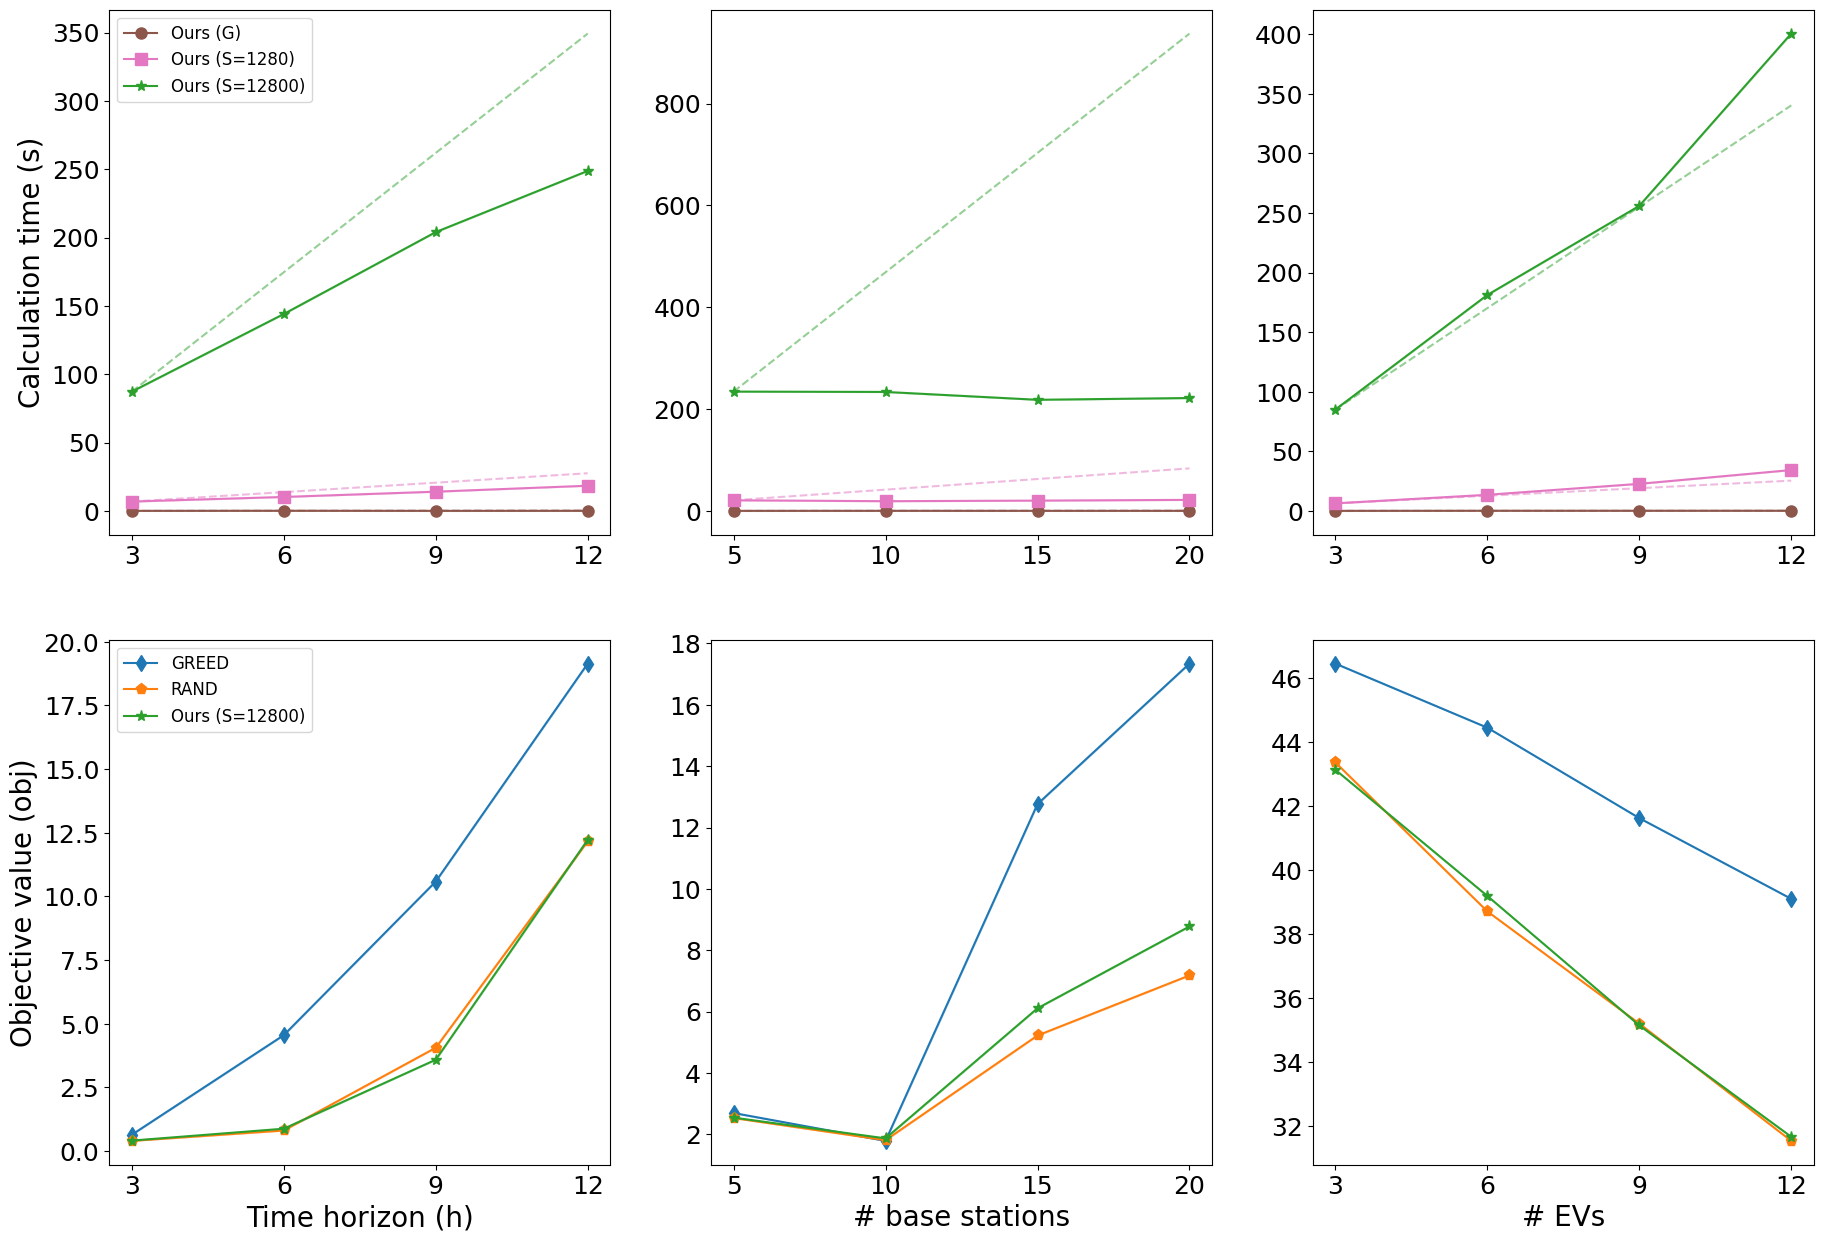

In [27]:
fig = plt.figure(figsize=(22, 15))
ax_timehorizon = {"time": fig.add_subplot(2, 3, 1), "obj": fig.add_subplot(2, 3, 4)}
ax_nlocs       = {"time": fig.add_subplot(2, 3, 2), "obj": fig.add_subplot(2, 3, 5)}
ax_nevs        = {"time": fig.add_subplot(2, 3, 3), "obj": fig.add_subplot(2, 3, 6)}

#------------------
# for time horizon
#------------------
def get_time_horizon_fname(model_name, time_horizon_):
    return f"results/test_time_horizon/{model_name}_time_horizon{time_horizon_}" + "/summary.json"
timehorizon_res = plot_scale_gen_res(eval_model_list, ax_timehorizon, time_horizon_list, get_time_horizon_fname, xlabel="Time horizon (h)", ylabel_scale="Calculation time (s)", ylabel_gen="Objective value (obj)")
ax_timehorizon["time"].legend(fontsize=12)
ax_timehorizon["obj"].legend(fontsize=12)

#---------------
# for num nodes
#---------------
def get_nlocs_fname(model_name, num_locs_):
    return f"results/test_num_locs/{model_name}_num_locs{num_locs_}" + "/summary.json"
nlocs_res = plot_scale_gen_res(eval_model_list, ax_nlocs, num_loc_list, get_nlocs_fname, xlabel="# base stations")

#-------------
# for num evs
#-------------
def get_nevs_fname(model_name, num_evs_):
    return f"results/test_num_evs/{model_name}_num_evs{num_evs_}" + "/summary.json"
nevs_res = plot_scale_gen_res(eval_model_list, ax_nevs, num_ev_list, get_nevs_fname, xlabel="# EVs")